# Model Optimization Assisting Efficient COVID-19 Vaccine Distribution

Eva Wu & Roy Xiao

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# Helps to display all rows and columns in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
dfcov = pd.read_csv('Covid002.csv', encoding = 'latin-1')
print(dfcov.shape)
dfcov.head()

(3107, 93)


,county,state,fips,cases,deaths,population,casespc,deathspc,cty,county_name,cty_pop2000,cz,cz_name,cz_pop2000,statename,state_id,stateabbrv,csa,csa_name,cbsa,cbsa_name,intersects_msa,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,bmi_obese_q1,bmi_obese_q2,bmi_obese_q3,bmi_obese_q4,exercise_any_q1,exercise_any_q2,exercise_any_q3,exercise_any_q4,brfss_mia,puninsured2010,reimb_penroll_adj10,mort_30day_hosp_z,adjmortmeas_amiall30day,adjmortmeas_chfall30day,adjmortmeas_pnall30day,med_prev_qual_z,primcarevis_10,diab_hemotest_10,diab_eyeexam_10,diab_lipids_10,mammogram_10,amb_disch_per1000_10,cs00_seg_inc,cs00_seg_inc_pov25,cs00_seg_inc_aff75,cs_race_theil_2000,gini99,poor_share,inc_share_1perc,frac_middleclass,scap_ski90pcm,rel_tot,cs_frac_black,cs_frac_hisp,unemp_rate,pop_d_2000_1980,lf_d_2000_1980,cs_labforce,cs_elf_ind_man,cs_born_foreign,mig_inflow,mig_outflow,pop_density,frac_traveltime_lt15,hhinc00,median_house_value,ccd_exp_tot,ccd_pup_tch_ratio,score_r,dropout_r,cs_educ_ba,tuition,gradrate_r,e_rank_b,cs_fam_wkidsinglemom,crime_total,subcty_exp_pc,taxrate,tax_st_diff_top20,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax,pm25,bmdeaths,bmcruderate,pm25_mia
0,Autauga,Alabama,1001,4434,152,918492,482.74780,16.548864,1001,Autauga,43671,11101,Montgomery,367927,Alabama,1,AL,NaN,NaN,33860.0,"Montgomery, AL",1,0.333333,0.238095,0.208333,0.133333,0.375000,0.238095,0.260870,0.133333,0.500000,0.666667,0.666667,0.800000,0,13.601278,9489.02,0.799735,0.146564,0.111778,0.150040,0.574764,85.528270,84.771574,72.419628,83.925550,68.465909,70.95,0.036455,0.043313,0.037231,0.128216,0.379976,0.109228,0.06143,0.51950,-0.897834,56.112755,17.008999,1.396808,0.037379,0.353762,0.527531,0.651493,0.164787,1.165533,0.057040,0.051018,73.277412,0.233124,34379.539,126368.4,4.460057,19.715980,-7.308133,0.003901,18.0,NaN,NaN,41.872879,0.191595,0.009353,1059.66930,0.011183,0.0,306.02344,96.055420,288.08508,85.651848,11.712587,7893,859.29999,0
1,Baldwin,Alabama,1003,10465,278,3102984,337.25601,8.959118,1003,Baldwin,140415,11001,Mobile,599405,Alabama,1,AL,380.0,"Mobile-Daphne-Fairhope, AL",19300.0,"Daphne-Fairhope-Foley, AL",1,0.268097,0.233503,0.167464,0.176991,0.298050,0.262467,0.193237,0.135747,0.599432,0.748677,0.835000,0.837963,0,19.085325,9618.34,-0.113602,0.145558,0.107229,0.115543,0.118566,83.215372,80.871050,64.047822,78.992314,69.873998,56.21,0.032571,0.021566,0.041103,0.100549,0.489738,0.101471,0.12719,0.49911,-0.362414,47.242817,10.224691,1.756223,0.039112,0.787451,1.037689,0.598249,0.125441,2.105901,0.044860,0.023537,87.960236,0.295529,39219.598,163292.5,4.596590,16.850983,-13.628747,0.002539,23.1,2055.6699,-0.247166,44.492390,0.186778,0.007371,2209.91040,0.011756,0.0,305.51663,97.971542,290.20886,89.730972,10.077723,30292,976.20001,0
2,Barbour,Alabama,1005,3157,33,499262,632.33331,6.609756,1005,Barbour,29038,10301,Eufaula,61458,Alabama,1,AL,NaN,NaN,NaN,NaN,0,0.228571,0.250000,0.181818,0.111111,0.294118,0.571429,0.545455,0.277778,0.542857,0.571429,0.909091,0.722222,0,18.513805,9761.77,0.552571,0.169922,0.107575,0.125935,0.067363,88.866842,85.831622,67.556468,81.519507,64.768683,109.26,0.021680,0.021777,0.020898,0.039993,0.490637,0.267998,0.09734,0.40833,-1.499349,41.170193,46.039669,1.646119,0.068132,0.172968,0.145003,0.480174,0.313745,1.498037,0.016565,0.023073,32.814877,0.394128,24274.195,91443.8,4.734407,16.656711,-15.955111,-0.007111,10.9,NaN,NaN,37.718758,0.337853,0.007748,1570.24830,0.012059,0.0,306.06226,97.371674,289.24210,88.633575,10.981967,5197,1040.90000,0
3,Bibb,Alabama,1007,2291,24,397470,576.39569,6.038192,1007,Bibb,20826,10801,Tuscaloosa,261112,Alabama,1,AL,142.0,"Birmingham-Hoover-Talladega, AL",13820.0,"Birmingham-Hoover, AL",1,0.244444,0.280000,0.181818,0.150000,0.466667,0.375000,0.190476,0.100000,0.422222,0.560000,0.681818,0.750000,0,17.718826,11269.81,1.857274,0.234408,0.112190,0.129624,-0.235594,83.723878,85.478548,64.356436,80.528053,57.228916,87.33,0.017462,0.028094,0.002048,0.103550,0.417098,0.206075,0.06622,0.46136,-0.9

## 1. Filter & Clean

In [7]:
# pull out the column of variables' names into a separate list
dfdict = pd.read_csv('vardes.csv')
predlist = dfdict['Variable'].tolist()

In [106]:
# then subset variables in our dataframe based on this list, removing 'casespc'
df = dfcov[np.intersect1d(dfcov.columns, predlist)]
df = df.drop(['casespc'], axis = 1)
df.head()

,adjmortmeas_amiall30day,adjmortmeas_chfall30day,bmcruderate,bmi_obese_q1,bmi_obese_q2,bmi_obese_q3,bmi_obese_q4,brfss_mia,ccd_exp_tot,cs00_seg_inc,cs00_seg_inc_aff75,cs00_seg_inc_pov25,cs_born_foreign,cs_elf_ind_man,cs_fam_wkidsinglemom,cs_frac_black,cs_frac_hisp,cs_labforce,cs_race_theil_2000,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,deathspc,diab_eyeexam_10,diab_hemotest_10,diab_lipids_10,exercise_any_q1,exercise_any_q2,exercise_any_q3,exercise_any_q4,frac_middleclass,frac_traveltime_lt15,gini99,hhinc00,inc_share_1perc,intersects_msa,mammogram_10,med_prev_qual_z,median_house_value,mig_inflow,mig_outflow,mort_30day_hosp_z,pm25,pm25_mia,poor_share,pop_density,primcarevis_10,puninsured2010,reimb_penroll_adj10,rel_tot,scap_ski90pcm,score_r,subcty_exp_pc,summer_rmax,summer_tmmx,tax_st_diff_top20,taxrate,unemp_rate,winter_rmax,winter_tmmx
0,0.146564,0.111778,859.29999,0.375000,0.238095,0.260870,0.133333,0,4.460057,0.036455,0.037231,0.043313,1.165533,0.164787,0.191595,17.008999,1.396808,0.651493,0.128216,0.333333,0.238095,0.208333,0.133333,16.548864,72.419628,84.771574,83.925550,0.500000,0.666667,0.666667,0.800000,0.51950,0.233124,0.379976,34379.539,0.06143,1,68.465909,0.574764,126368.4,0.057040,0.051018,0.799735,11.712587,0,0.109228,73.277412,85.528270,13.601278,9489.02,56.112755,-0.897834,-7.308133,1059.66930,96.055420,306.02344,0.0,0.011183,0.037379,85.651848,288.08508
1,0.145558,0.107229,976.20001,0.298050,0.262467,0.193237,0.135747,0,4.596590,0.032571,0.041103,0.021566,2.105901,0.125441,0.186778,10.224691,1.756223,0.598249,0.100549,0.268097,0.233503,0.167464,0.176991,8.959118,64.047822,80.871050,78.992314,0.599432,0.748677,0.835000,0.837963,0.49911,0.295529,0.489738,39219.598,0.12719,1,69.873998,0.118566,163292.5,0.044860,0.023537,-0.113602,10.077723,0,0.101471,87.960236,83.215372,19.085325,9618.34,47.242817,-0.362414,-13.628747,2209.91040,97.971542,305.51663,0.0,0.011756,0.039112,89.730972,290.20886
2,0.169922,0.107575,1040.90000,0.294118,0.571429,0.545455,0.277778,0,4.734407,0.021680,0.020898,0.021777,1.498037,0.313745,0.337853,46.039669,1.646119,0.480174,0.039993,0.228571,0.250000,0.181818,0.111111,6.609756,67.556468,85.831622,81.519507,0.542857,0.571429,0.909091,0.722222,0.40833,0.394128,0.490637,24274.195,0.09734,0,64.768683,0.067363,91443.8,0.016565,0.023073,0.552571,10.981967,0,0.267998,32.814877,88.866842,18.513805,9761.77,41.170193,-1.499349,-15.955111,1570.24830,97.371674,306.06226,0.0,0.012059,0.068132,88.633575,289.24210
3,0.234408,0.112190,1028.80000,0.466667,0.375000,0.190476,0.100000,0,4.154157,0.017462,0.002048,0.028094,0.427350,0.237480,0.197729,22.010948,1.008355,0.528893,0.103550,0.244444,0.280000,0.181818,0.150000,6.038192,64.356436,85.478548,80.528053,0.422222,0.560000,0.681818,0.750000,0.46136,0.246582,0.417098,24927.521,0.06622,1,57.228916,-0.235594,99441.8,0.035821,0.029338,1.857274,11.998714,0,0.206075,33.427227,83.723878,17.718826,11269.81,46.365120,-0.930472,-14.839100,1338.44120,96.293076,305.98218,0.0,0.008007,0.061639,86.485870,287.36282
4,0.177953,0.117951,993.70001,0.347826,0.318182,0.529412,0.235294,0,3.998976,0.013379,0.013171,0.015049,3.098542,0.195234,0.121988,1.171997,5.326905,0.605729,0.079703,0.304348,0.260870,0.352941,0.166667,1.503713,68.155340,84.466019,79.223301,0.565217,0.478261,0.705882,0.722222,0.59722,0.213904,0.333042,30229.857,0.06281,1,66.025641,-0.003070,115704.4,0.038825,0.033572,1.781737,11.793022,0,0.117428,79.035255,84.625169,19.280413,10238.20,50.791782,-1.304095,-10.218139,987.43884,94.630951,305.17886,0.0,0.007012,0.032847,85.449142,285.56567


In [107]:
# add the county & state for each observation + shifting outcome var 'deathspc' to front
directory = dfcov.iloc[:, 0:2] # extract county & state
df = pd.concat([directory, df], axis = 1)
column_to_move = df.pop('deathspc') # move deathspc to the front
df.insert(2, 'deathspc', column_to_move)
df.head()

,county,state,deathspc,adjmortmeas_amiall30day,adjmortmeas_chfall30day,bmcruderate,bmi_obese_q1,bmi_obese_q2,bmi_obese_q3,bmi_obese_q4,brfss_mia,ccd_exp_tot,cs00_seg_inc,cs00_seg_inc_aff75,cs00_seg_inc_pov25,cs_born_foreign,cs_elf_ind_man,cs_fam_wkidsinglemom,cs_frac_black,cs_frac_hisp,cs_labforce,cs_race_theil_2000,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,diab_eyeexam_10,diab_hemotest_10,diab_lipids_10,exercise_any_q1,exercise_any_q2,exercise_any_q3,exercise_any_q4,frac_middleclass,frac_traveltime_lt15,gini99,hhinc00,inc_share_1perc,intersects_msa,mammogram_10,med_prev_qual_z,median_house_value,mig_inflow,mig_outflow,mort_30day_hosp_z,pm25,pm25_mia,poor_share,pop_density,primcarevis_10,puninsured2010,reimb_penroll_adj10,rel_tot,scap_ski90pcm,score_r,subcty_exp_pc,summer_rmax,summer_tmmx,tax_st_diff_top20,taxrate,unemp_rate,winter_rmax,winter_tmmx
0,Autauga,Alabama,16.548864,0.146564,0.111778,859.29999,0.375000,0.238095,0.260870,0.133333,0,4.460057,0.036455,0.037231,0.043313,1.165533,0.164787,0.191595,17.008999,1.396808,0.651493,0.128216,0.333333,0.238095,0.208333,0.133333,72.419628,84.771574,83.925550,0.500000,0.666667,0.666667,0.800000,0.51950,0.233124,0.379976,34379.539,0.06143,1,68.465909,0.574764,126368.4,0.057040,0.051018,0.799735,11.712587,0,0.109228,73.277412,85.528270,13.601278,9489.02,56.112755,-0.897834,-7.308133,1059.66930,96.055420,306.02344,0.0,0.011183,0.037379,85.651848,288.08508
1,Baldwin,Alabama,8.959118,0.145558,0.107229,976.20001,0.298050,0.262467,0.193237,0.135747,0,4.596590,0.032571,0.041103,0.021566,2.105901,0.125441,0.186778,10.224691,1.756223,0.598249,0.100549,0.268097,0.233503,0.167464,0.176991,64.047822,80.871050,78.992314,0.599432,0.748677,0.835000,0.837963,0.49911,0.295529,0.489738,39219.598,0.12719,1,69.873998,0.118566,163292.5,0.044860,0.023537,-0.113602,10.077723,0,0.101471,87.960236,83.215372,19.085325,9618.34,47.242817,-0.362414,-13.628747,2209.91040,97.971542,305.51663,0.0,0.011756,0.039112,89.730972,290.20886
2,Barbour,Alabama,6.609756,0.169922,0.107575,1040.90000,0.294118,0.571429,0.545455,0.277778,0,4.734407,0.021680,0.020898,0.021777,1.498037,0.313745,0.337853,46.039669,1.646119,0.480174,0.039993,0.228571,0.250000,0.181818,0.111111,67.556468,85.831622,81.519507,0.542857,0.571429,0.909091,0.722222,0.40833,0.394128,0.490637,24274.195,0.09734,0,64.768683,0.067363,91443.8,0.016565,0.023073,0.552571,10.981967,0,0.267998,32.814877,88.866842,18.513805,9761.77,41.170193,-1.499349,-15.955111,1570.24830,97.371674,306.06226,0.0,0.012059,0.068132,88.633575,289.24210
3,Bibb,Alabama,6.038192,0.234408,0.112190,1028.80000,0.466667,0.375000,0.190476,0.100000,0,4.154157,0.017462,0.002048,0.028094,0.427350,0.237480,0.197729,22.010948,1.008355,0.528893,0.103550,0.244444,0.280000,0.181818,0.150000,64.356436,85.478548,80.528053,0.422222,0.560000,0.681818,0.750000,0.46136,0.246582,0.417098,24927.521,0.06622,1,57.228916,-0.235594,99441.8,0.035821,0.029338,1.857274,11.998714,0,0.206075,33.427227,83.723878,17.718826,11269.81,46.365120,-0.930472,-14.839100,1338.44120,96.293076,305.98218,0.0,0.008007,0.061639,86.485870,287.36282
4,Blount,Alabama,1.503713,0.177953,0.117951,993.70001,0.347826,0.318182,0.529412,0.235294,0,3.998976,0.013379,0.013171,0.015049,3.098542,0.195234,0.121988,1.171997,5.326905,0.605729,0.079703,0.304348,0.260870,0.352941,0.166667,68.155340,84.466019,79.223301,0.565217,0.478261,0.705882,0.722222,0.59722,0.213904,0.333042,30229.857,0.06281,1,66.025641,-0.003070,115704.4,0.038825,0.033572,1.781737,11.793022,0,0.117428,79.035255,84.625169,19.280413,10238.20,50.791782,-1.304095,-10.218139,987.43884,94.630951,305.17886,0.0,0.007012,0.032847,85.449142,285.56567


Reference: [extract list from column names](https://stackoverflow.com/questions/22341271/get-list-from-pandas-dataframe-column-or-row), [select columns by list](https://stackoverflow.com/questions/40636514/selecting-columns-by-list-and-columns-are-subset-of-list), [rearrange columns](https://www.stackvidhya.com/change-order-of-columns-in-pandas-dataframe/)

## 2. Summary Statistics

In [108]:
df.iloc[:, 2:].describe() # not include county and state

,deathspc,adjmortmeas_amiall30day,adjmortmeas_chfall30day,bmcruderate,bmi_obese_q1,bmi_obese_q2,bmi_obese_q3,bmi_obese_q4,brfss_mia,ccd_exp_tot,cs00_seg_inc,cs00_seg_inc_aff75,cs00_seg_inc_pov25,cs_born_foreign,cs_elf_ind_man,cs_fam_wkidsinglemom,cs_frac_black,cs_frac_hisp,cs_labforce,cs_race_theil_2000,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,diab_eyeexam_10,diab_hemotest_10,diab_lipids_10,exercise_any_q1,exercise_any_q2,exercise_any_q3,exercise_any_q4,frac_middleclass,frac_traveltime_lt15,gini99,hhinc00,inc_share_1perc,intersects_msa,mammogram_10,med_prev_qual_z,median_house_value,mig_inflow,mig_outflow,mort_30day_hosp_z,pm25,pm25_mia,poor_share,pop_density,primcarevis_10,puninsured2010,reimb_penroll_adj10,rel_tot,scap_ski90pcm,score_r,subcty_exp_pc,summer_rmax,summer_tmmx,tax_st_diff_top20,taxrate,unemp_rate,winter_rmax,winter_tmmx
count,3107.000000,3106.000000,3107.000000,3107.00000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3080.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3054.000000,3069.000000,3057.000000,3107.000000,3107.000000,3107.000000,3107.000000,3106.000000,3107.000000,3008.000000,3107.000000,3008.000000,3107.000000,3029.000000,3012.000000,3.107000e+03,3017.000000,3017.000000,3106.000000,3107.000000,3107.000000,3107.000000,3107.000000,3098.000000,3107.000000,3103.000000,3106.000000,3107.000000,3069.000000,3107.000000,3107.000000,3107.000000,3106.000000,3107.000000,3107.000000,3107.000000,3107.000000
mean,23.790131,0.165483,0.108969,1029.15597,0.239166,0.214580,0.209621,0.186739,0.249437,6.092697,0.025892,0.026463,0.024278,3.441958,0.159118,0.194598,8.744503,6.209190,0.609344,0.075402,0.212659,0.171048,0.134467,0.098316,66.080221,83.706025,78.307420,0.455995,0.555671,0.603792,0.638727,0.554244,0.403803,0.379021,32853.502978,0.094808,0.596717,63.110073,-0.148547,1.121801e+05,0.028677,0.027522,0.457806,8.371871,0.003540,0.141739,244.325026,80.865348,18.469460,9302.737743,53.224564,0.000182,0.077348,2119.407531,88.970517,303.126997,0.775634,0.023089,0.049871,87.469432,280.404875
std,67.852145,0.039408,0.023565,248.38181,0.165928,0.153237,0.175849,0.167227,0.432757,2.103573,0.030576,0.032920,0.030757,4.836270,0.090862,0.067828,14.483719,12.050404,0.070393,0.084131,0.149348,0.128130,0.132181,0.110110,7.598549,6.594153,7.854145,0.273874,0.322336,0.357861,0.376922,0.093099,0.137215,0.086677,6975.837500,0.050631,0.490636,8.397699,0.863881,6.318905e+04,0.019034,0.013780,1.206493,2.565927,0.059405,0.065460,1676.096088,7.401457,5.536651,1590.926253,18.502524,1.347960,9.007980,999.833466,9.689271,3.173950,1.470989,0.013848,0.017738,4.811207,6.597855
min,0.000000,0.000000,0.000000,189.30000,0.000000,0.000000,0.000000,0.000000,0.000000,3.032457,-0.013363,-0.001993,-0.019502,0.000000,0.000000,0.024793,0.000000,0.082034,0.319209,0.000000,0.000000,0.000000,0.000000,0.000000,31.372549,16.911765,19.661336,0.000000,0.000000,0.000000,0.000000,0.215630,0.099878,0.160954,10511.805000,0.018570,0.000000,30.000000,-4.853847,0.000000e+00,0.000000,0.000000,-7.778000,0.000000,0.000000,0.000000,0.099542,18.331749,3.625483,3663.530000,1.816347,-4.258739,-38.687138,0.000000,31.643282,290.455540,0.000000,0.000000,0.016092,58.159798,264.693820
25%,0.000000,0.145312,0.096301,864.29999,0.080128,0.000000,0.000000,0.000000,0.000000,5.027049,0.005047,0.003455,0.004164,0.898505,0.088637,0.152436,0.264501,0.917235,0.567037,0.015591,0.000000,0.000000,0.000000,0.000000,61.258165,81.108462,75.000000,0.312500,0.444444,0.354167,0.400000,0.491883,0.299927,0.317518,28733.524500,0.062577,0.000000,57.943925,-0.615591,7.704740e+04,0.016502,0.018767,-0.255867,6.309710,0.000000,0.095383,17.479568,78.803466,14.410248,8159.340000,39.669796,-0.964225,-4.969633,1510.192750,88.052494,300.848035,0.000000,0.014993,0.037422,85.093342,275.113020
50%,3.802303,0.162727,0.107242,1036.30000,0.272076,0.241590,0.223124,0.194

## 3. Drop NA's

In [109]:
df = df.dropna()
print(df.shape)

(2915, 63)


*Note: should replace NA's with mean for more accurate analyses*

## 4. Dummies for States

In [110]:
df = pd.get_dummies(df, columns = ['state']) # can be run only once

In [111]:
df.describe()

,deathspc,adjmortmeas_amiall30day,adjmortmeas_chfall30day,bmcruderate,bmi_obese_q1,bmi_obese_q2,bmi_obese_q3,bmi_obese_q4,brfss_mia,ccd_exp_tot,cs00_seg_inc,cs00_seg_inc_aff75,cs00_seg_inc_pov25,cs_born_foreign,cs_elf_ind_man,cs_fam_wkidsinglemom,cs_frac_black,cs_frac_hisp,cs_labforce,cs_race_theil_2000,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,diab_eyeexam_10,diab_hemotest_10,diab_lipids_10,exercise_any_q1,exercise_any_q2,exercise_any_q3,exercise_any_q4,frac_middleclass,frac_traveltime_lt15,gini99,hhinc00,inc_share_1perc,intersects_msa,mammogram_10,med_prev_qual_z,median_house_value,mig_inflow,mig_outflow,mort_30day_hosp_z,pm25,pm25_mia,poor_share,pop_density,primcarevis_10,puninsured2010,reimb_penroll_adj10,rel_tot,scap_ski90pcm,score_r,subcty_exp_pc,summer_rmax,summer_tmmx,tax_st_diff_top20,taxrate,unemp_rate,winter_rmax,winter_tmmx,state_Alabama,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_Florida,state_Georgia,state_Idaho,state_Illinois,state_Indiana,state_Iowa,state_Kansas,state_Kentucky,state_Louisiana,state_Maine,state_Maryland,state_Massachusetts,state_Michigan,state_Minnesota,state_Mississippi,state_Missouri,state_Montana,state_Nebraska,state_Nevada,state_New Hampshire,state_New Mexico,state_New York,state_North Carolina,state_North Dakota,state_Ohio,state_Oklahoma,state_Oregon,state_Pennsylvania,state_Rhode Island,state_South Carolina,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
count,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2.915000e+03,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000,2915.000000
mean,22.508358,0.166352,0.109098,1029.440137,0.250144,0.224401,0.219795,0.195517,0.215094,5.965086,0.026481,0.027151,0.024796,3.371631,0.165361,0.197279,9.002642,6.112912,0.608734,0.077710,0.222676,0.178464,0.140208,0.103128,65.984913,83.782636,78.428339,0.476171,0.580185,0.631002,0.666982,0.553645,0.396968,0.379442,32772.045225,0.094566,0.612350,63.044018,-0.161696,1.129262e+05,0.028810,0.027460,0.483962,8.526459,0.002401,0.140969,229.836144,80.911496,18.253480,9354.372857,52.832850,-0.048794,-0.077128,2080.445692,89.308940,303.144595,0.737866,0.022005,0.050540,87.560970,280.509352,0.022985,0.005146,0.025386,0.019554,0.017496,0.002744,0.001029,0.022985,0.052830,0.013722,0.034991,0.031561,0.033619,0.031561,0.040823,0.021955,0.005489,0.007204,0.004803,0.028130,0.029160,0.027787,0.038765,0.014065,0.023671,0.004803,0.003431,0.010635,0.020926,0.034305,0.014065,0.030189,0.025729,0.011321,0.022985,0.001715,0.015780,0.017839,0.032590,0.078559,0.008233,0.004803,0.040137,0.013379,0.018868,0.024700,0.007547
std,52.199827,0.033087,0.019315,241.287000,0.161168,0.149001,0.174383,0.165610,0.410958,1.641041,

## 5. Split Sample

In [112]:
df = df.set_index(['county']) # set county as index

In [113]:
X = df.drop(['deathspc'], axis = 1)
y = df[['deathspc']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 25)

## 6. OLS

### a) MSE in training & validation sets

In [114]:
ols = LinearRegression(fit_intercept = True)
ols.fit(X_train, y_train)

y_pred_training = ols.predict(X_train)
print('MSE of OLS model fitted onto training set: ', mean_squared_error(y_train, y_pred_training))

y_pred_val = ols.predict(X_val)
print('MSE of OLS model fitted onto validation set: ', mean_squared_error(y_val, y_pred_val))

MSE of OLS model fitted onto training set:  1561.857307690756
MSE of OLS model fitted onto validation set:  1927.2484718467585


### b) Evidence of overfitting?

Under our original split of the dataset (with random_state = 25), we find that the OLS model trained on our training set has a **higher validation-set mean squared error (MSE) than training-set MSE**. This is usually a sign that our predictive model is overfitting onto the data in the training set. As we include many predictors in our model, the model will fit flexibly on the data we have in the training set and this reduces model bias. However, greater model flexibility simultaneously results in greater training variance, resulting in a bias-variance trade-off that could increase MSE when the model is fitted onto the validation set. In this case, we might infer that the model we specified is overly flexible and thus suffers from overfitting when fitted onto the validation set.

The Validation Set approach suffers from high variability when we use it to estimate the test error of our model, because the validation estimate of the test error changes based on how we split the data. 

## 7. Model Regularisation - Ridge & Lasso

### **Ridge Regression:**

#### a) Estimate the test error of 100 Ridge Regression models with different tuning parameter values (ranging from 0.01 to 100) using 10-fold Cross Validation:

In [115]:
ridge = Ridge(normalize = True) # normalize is essential in RR

# Defining set of regularization parameters - alpha (aka the tuning parameter lambda in the Ridge Regression equation)
# Note that we must use 'alpha' to term the reg param, specifically coded as such in Ridge & Lasso
# Taking 10 to the power of the set of numbers from -2 to 2 (with 100 intervals)
alpha_param = (10**np.linspace(start = -2, stop = 2, num = 100))

In [116]:
# train Ridge rergession using multiple values of alpha from the list of params defined above 
# calculate a vector of mean and standard deviation values for each parameter (MSE of RR model with some alpha)

def vector_values(grid_search, trials):
    mean_vec = np.zeros(trials) # an array w/ 'trials' # of 0s
    std_vec = np.zeros(trials)
    i = 0
    final = grid_search.cv_results_
    
    # Using Grid Search's 'cv_results' attribute to get mean and std for each parameter
    for mean_score, std_score in zip(final["mean_test_score"], final["std_test_score"]):
        mean_vec[i] = -mean_score # negative sign used to get positive MSE
        std_vec[i] = std_score
        i = i + 1

    return mean_vec, std_vec

In [117]:
# Creating a parameters grid
param_grid = [{'alpha': alpha_param }]

# Running Grid Search over the alpha (regularization) parameter,
# to obtain the estimated test MSE (10-fold CV error) of each RR model w/ different lambda
grid_search_ridge = GridSearchCV(ridge, param_grid, cv = 10, scoring = 'neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(normalize=True),
             param_grid=[{'alpha': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.05385551e-02, 3.35160265e-02, 3.67837977e-02, 4.03701726e-02,
       4.43062146e-02, 4.86260158e-02, 5...
       1.17681195e+01, 1.29154967e+01, 1.41747416e+01, 1.55567614e+01,
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])}],
             scoring='neg_mean_squared_error')

#### b) Plot 10FCV estimates of test error as a function of lambda value

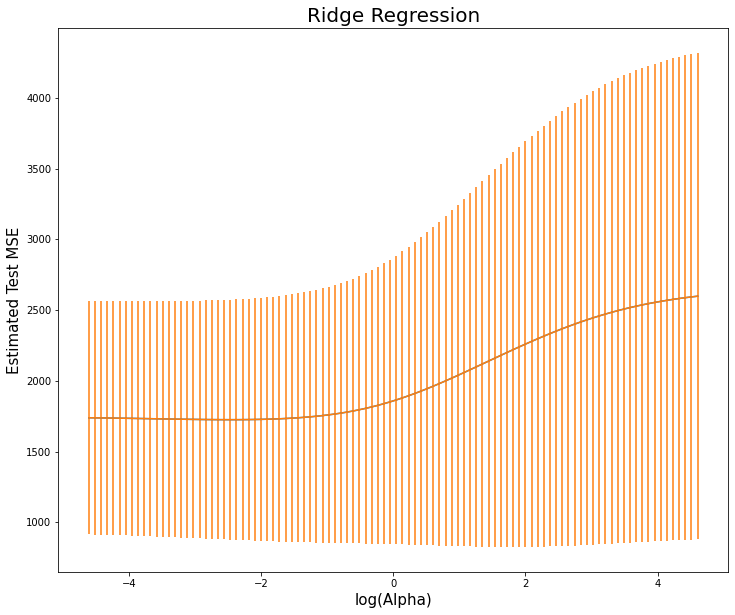

In [118]:
# Applying the vector_values function we created to calculate mean and std dev of the estimated test MSE for each RR model
mean_vec, std_vec = vector_values(grid_search_ridge, 100)

plt.figure(figsize = (12, 10))
plt.title('Ridge Regression', fontsize = 20)
plt.plot(np.log(alpha_param), mean_vec) # base e
plt.errorbar(np.log(alpha_param), mean_vec, yerr = std_vec)
plt.ylabel('Estimated Test MSE', fontsize = 15)
plt.xlabel('log(Alpha)', fontsize = 15)
plt.show()

# Plot y versus x as lines and/or markers with attached errorbars.
# x, y define the data locations, xerr, yerr define the errorbar sizes. 
# By default, this draws the data markers/lines as well the errorbars. Use fmt='none' to draw errorbars without 
# any data markers.

#### c) Choose optimal lambda

In [119]:
# Find the optimal MSE score --> lowest MSE
print('Minimal 10-fold CV error rate (estimated test error): ', min(mean_vec))

# Optimal alpha --> one that minimizes MSE
print('Optimal tuning parameter value: ', alpha_param[np.where(mean_vec == min(mean_vec))][0])

Minimal 10-fold CV error rate (estimated test error):  1725.783200975835
Optimal tuning parameter value:  0.08497534359086446


#### d) Re-estimate using optimal lambda

In [120]:
ridge_optimal = Ridge(alpha = alpha_param[np.where(mean_vec == min(mean_vec))][0], fit_intercept = True, normalize = True)
ridge_optimal.fit(X_train, y_train)
ridge_optimal.coef_

array([[-5.52354362e+00,  7.26861602e+00,  2.62173247e-03,
        -3.04356240e+00,  4.20809248e+00, -1.59563057e+01,
         2.15227316e+00, -6.34129038e-01,  1.26844000e+00,
         1.40665081e+01,  3.50779400e+01, -1.32973055e+02,
         1.08527605e+00,  3.37697609e+01,  1.88687564e+01,
         5.76526142e-01, -5.61030407e-02, -3.89741402e+01,
         1.60680618e+01, -8.03701310e-01,  1.00090006e+00,
         3.71427283e+00,  8.62611112e+00,  1.89752783e-01,
        -5.30680721e-01,  1.27104575e-02, -1.45339124e+00,
         1.52811314e+01, -4.60849519e+00, -6.50694873e+00,
        -7.11976793e+01, -1.44208068e+01, -1.02675444e+01,
         6.41061566e-04, -1.70387149e+00,  2.66239208e+00,
        -9.92555781e-03,  1.75880319e+00,  5.35484303e-05,
        -1.17885548e+02, -1.91552648e+02,  7.41837676e-01,
         3.80606207e-01, -5.20449990e+00,  3.10601340e+00,
         6.89749505e-03,  1.16503612e-03, -7.85960359e-01,
        -5.74449463e-04,  1.15287491e-01, -3.47726764e+0

### **LASSO method:**

#### a) Estimate the test error of 100 Lasso models with different tuning parameter values (ranging from 0.01 to 100) using 10-fold Cross Validation:

In [121]:
lasso = Lasso(normalize = True)

# Defining set of regularization parameters - alpha (aka the tuning parameter lambda in the Lasso equation)
# Note that we must use 'alpha' to term the reg param, specifically coded as such in Ridge & Lasso
# Taking 10 to the power of the set of numbers from -3 to 1 (with 100 intervals)
alpha_param = (10**np.linspace(start = -3, stop = 1, num = 100)) # shift range in order to find optimal value

In [122]:
# Creating a parameters grid
param_grid = [{'alpha': alpha_param }]

# Running Grid Search over the alpha (regularization) parameter
grid_search_lasso = GridSearchCV(lasso, param_grid, cv = 10, scoring = 'neg_mean_squared_error')
grid_search_lasso.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Lasso(normalize=True),
             param_grid=[{'alpha': array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03, 4.03701726e-03,
       4.43062146e-03, 4.86260158e-03, 5...
       1.17681195e+00, 1.29154967e+00, 1.41747416e+00, 1.55567614e+00,
       1.70735265e+00, 1.87381742e+00, 2.05651231e+00, 2.25701972e+00,
       2.47707636e+00, 2.71858824e+00, 2.98364724e+00, 3.27454916e+00,
       3.59381366e+00, 3.94420606e+00, 4.32876128e+00, 4.75081016e+00,
       5.21400829e+00, 5.72236766e+00, 6.28029144e+00, 6.89261210e+00,
       7.56463328e+00, 8.30217568e+00, 9.11162756e+00, 1.00000000e+01])}],
             scoring='neg_mean_squared_error')

#### b) Plot 10FCV estimates of test error as a function of lambda value

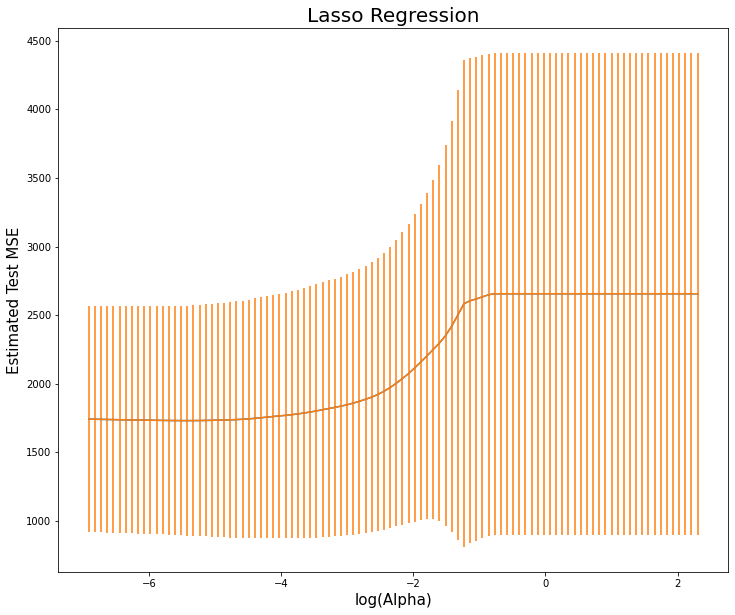

In [123]:
# Applying the vector_values function we created to calculate mean and std dev of the estimated test MSE for each Lasso model
mean_vec, std_vec = vector_values(grid_search_lasso, 100)

plt.figure(figsize = (12,10))
plt.title('Lasso Regression', fontsize = 20)
plt.plot(np.log(alpha_param), mean_vec)
plt.errorbar(np.log(alpha_param), mean_vec, yerr = std_vec)
plt.ylabel("Estimated Test MSE", fontsize = 15)
plt.xlabel("log(Alpha)", fontsize = 15)
plt.show()

#### c) Choose optimal lambda

In [124]:
# Find the optimal MSE score --> lowest MSE
print('Minimal 10-fold CV error rate (estimated test error): ', min(mean_vec))

# Optimal alpha --> one that minimizes MSE
print('Optimal tuning parameter value: ', alpha_param[np.where(mean_vec == min(mean_vec))][0])

Minimal 10-fold CV error rate (estimated test error):  1729.3554197235583
Optimal tuning parameter value:  0.004430621457583882


#### d) Re-estimate using optimal lambda

In [125]:
lasso_optimal = Lasso(alpha = alpha_param[np.where(mean_vec == min(mean_vec))][0], normalize = True)
lasso_optimal.fit(X_train, y_train)
lasso_optimal.coef_

array([-0.00000000e+00,  2.07121656e+01,  1.57363718e-04, -1.10776948e+00,
        0.00000000e+00, -1.59535871e+01,  0.00000000e+00,  0.00000000e+00,
        9.81229515e-01,  0.00000000e+00,  1.61812565e+01, -1.21744198e+02,
        1.13329555e+00,  3.79219144e+01, -0.00000000e+00,  7.59247931e-01,
       -0.00000000e+00, -3.96932413e+01,  1.35815726e+01, -0.00000000e+00,
        0.00000000e+00,  1.80921365e+00,  6.68904182e+00,  1.14367494e-01,
       -5.69209377e-01,  0.00000000e+00, -0.00000000e+00,  1.94738643e+01,
       -4.23371311e+00, -7.14882754e+00, -8.22227305e+01, -8.90075800e+00,
       -1.28564019e+01,  9.31514029e-04, -0.00000000e+00,  2.41018966e+00,
       -0.00000000e+00,  2.04368967e+00,  6.90649328e-06, -9.01791008e+01,
       -2.38116872e+02,  3.71947961e-01,  0.00000000e+00, -1.41162840e+00,
       -0.00000000e+00,  8.10725651e-03,  0.00000000e+00, -8.53818080e-01,
       -4.54981259e-04,  9.27204448e-02, -3.84252475e+00,  1.55624135e-01,
        0.00000000e+00, -

## 8. Evaluation

In [126]:
y_pred_training = ols.predict(X_train)
print('MSE of OLS model fitted onto training set: ', mean_squared_error(y_train, y_pred_training))

y_pred_val = ols.predict(X_val)
print('MSE of OLS model fitted onto validation set: ', mean_squared_error(y_val, y_pred_val))

y_pred_training_ridge = ridge_optimal.predict(X_train)
print('MSE of RR model fitted onto training set: ', mean_squared_error(y_train, y_pred_training_ridge))

y_pred_val_ridge = ridge_optimal.predict(X_val)
print('MSE of RR model fitted onto validation set: ', mean_squared_error(y_val, y_pred_val_ridge))

y_pred_training_lasso = lasso_optimal.predict(X_train)
print('MSE of LASSO model fitted onto training set: ', mean_squared_error(y_train, y_pred_training_lasso))

y_pred_val_lasso = lasso_optimal.predict(X_val)
print('MSE of LASSO model fitted onto validation set: ', mean_squared_error(y_val, y_pred_val_lasso))

MSE of OLS model fitted onto training set:  1561.857307690756
MSE of OLS model fitted onto validation set:  1927.2484718467585
MSE of RR model fitted onto training set:  1584.5061729130412
MSE of RR model fitted onto validation set:  1919.5396540261922
MSE of LASSO model fitted onto training set:  1579.746859264915
MSE of LASSO model fitted onto validation set:  1880.376121119161


The validation-set error (in this case, the MSE of the model fitted onto data in the validation set) gives us an estimate of the true test error of the model, which is a measure of the predictive accuracy of a model. 

From our results above, we see that the Lasso model (optimally tuned using 10-fold Cross Validation) suffers the lowest validation-set error (1880.38). The Ridge Regression model (also optimally tuned using 10-fold Cross Validation) suffers a higher validation-set error (1919.54) than the Lasso model but lower than the OLS model. The OLS model has the highest validation-set error (1927.25). This implies that the Ridge Regression and the Lasso method of model regularization both improved the predictive accuracy of our model, but **the LASSO model performed the best**, and should thus be recommended to the CDC for predicting Covid-19 deaths per capita at the county-level.